## Reanalysis of published models of _Plasmodium_ Intraerythrocytic cycle (IEC) dynamics

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import popsynch as ps

def array2bnicematrix(a):
    lines = np.array2string(a, max_line_width=np.infty, formatter={'float_kind':lambda x: "%.3f" % x}).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bNiceMatrix}[first-col,first-row]']
    rv += ['  & ' + ' & '.join(np.array2string(np.arange(a.shape[0]), formatter={'float_kind':lambda x: "%.3f" % x}).replace('[', '').replace(']', '').split()) + '\\']
    rv += [f' {i} & ' + ' & '.join(l.split()) + '\\' for i,l in enumerate(lines)]
    rv +=  [r'\end{bNiceMatrix}']
    return ' '.join(rv)

### Reanalysis of the Greischar et al [1] hueristic, discrete-time model of Plasmodium IEC with replication

[1] Greischar MA, Reece SE, Savill NJ, Mideo N. The Challenge of Quantifying Synchrony in Malaria Parasites. Trends Parasitol. 2019 May;35(5):341-355. doi: 10.1016/j.pt.2019.03.002. Epub 2019 Apr 2. PMID: 30952484.

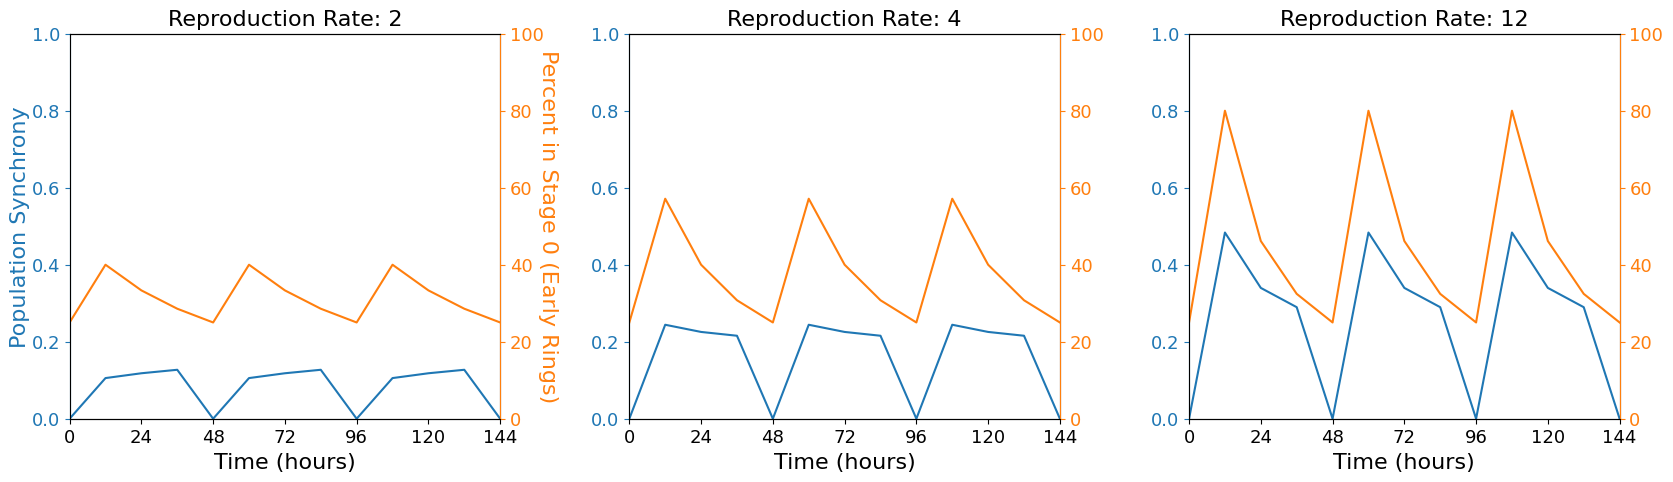

In [25]:
num_iter = 13
num_states = 4
rep_rates = [2, 4, 12]

fig, axs = plt.subplots(1, len(rep_rates), figsize=(20,5))
axs = axs.flatten()
plt.subplots_adjust(wspace=0.3)

init_pop = np.ones(num_states)
pop_dict = dict()
synch_dict = dict()
ai=0
for rep_rate in rep_rates:
    pop_dict[rep_rate] = np.zeros((num_iter, num_states), dtype=int)
    synch_dict[rep_rate] = np.zeros(num_iter)
    pop_dict[rep_rate][0,:] = init_pop
    synch_dict[rep_rate][0] = ps.discrete_uniform_circ_synchrony(init_pop)[0]
    
    transition_matrix = np.array([[0,1,0,0],[0,0,1,0],[0,0,0,1],[rep_rate, 0, 0, 0]])
    for i in range(1,num_iter):
        pop_dict[rep_rate][i,:] = np.dot(pop_dict[rep_rate][i-1,:],transition_matrix)
        synch_dict[rep_rate][i] = ps.discrete_uniform_circ_synchrony(pop_dict[rep_rate][i,:])[0]
    
    axs[ai].plot(48*np.arange(num_iter)/num_states, synch_dict[rep_rate], color='#1f77b4')
    ax2 = axs[ai].twinx()
    ax2.plot(48*np.arange(num_iter)/num_states, 100*pop_dict[rep_rate][:,0]/pop_dict[rep_rate].sum(axis=1), color='#ff7f0e')
    
    axs[ai].set_xlabel('Time (hours)', fontsize=16)

    if ai == 0:
        axs[ai].set_ylabel('Population Synchrony', fontsize=16, color='#1f77b4', labelpad=1)
    axs[ai].tick_params(axis='y', colors='#1f77b4', labelsize=13)
    axs[ai].spines['left'].set_color('#1f77b4')
    axs[ai].set_ylim(0,1)
    axs[ai].set_xticks(48*np.arange(0,num_iter,2)/num_states, labels=['0','24','48','72','96','120','144'], fontsize=13)
    axs[ai].set_xlim(0,144)
    if ai == 0:
        ax2.set_ylabel('Percent in Stage 0 (Early Rings)', fontsize=16, color='#ff7f0e', rotation=270, labelpad=10)
    ax2.tick_params(axis='y', colors='#ff7f0e', labelsize=13)
    ax2.spines['right'].set_color('#ff7f0e')
    ax2.set_ylim(0,100)

    axs[ai].set_title(f'Reproduction Rate: {rep_rate}', fontsize=16)

    ai+=1
plt.savefig('../figs/greischar_model_popsynch.svg')

## Reanalysis of experimental and simulated data reported in [2], computing synchrony measures for simulated parasite populations, inferred staging curves, and experimental staging curves measured by microscopy

[2] Smith LM, Motta FC, Chopra G, Moch JK, Nerem RR, Cummins B, Roche KE, Kelliher CM, Leman AR, Harer J, Gedeon T, Waters NC, Haase SB. An intrinsic oscillator drives the blood stage cycle of the malaria parasite Plasmodium falciparum. Science. 2020 May 15;368(6492):754-759. doi: 10.1126/science.aba4357. PMID: 32409472; PMCID: PMC7518718.

Strain: 3D7, transitions [0.312 0.602] Period: 39.0
Strain: D6, transitions [0.478 0.629] Period: 36.0
Strain: FVO, transitions [0.571 0.797] Period: 43.0
Strain: SA250, transitions [0.419 0.68 ] Period: 54.0
Strain: HB3, transitions [0.39  0.657] Period: 46.0


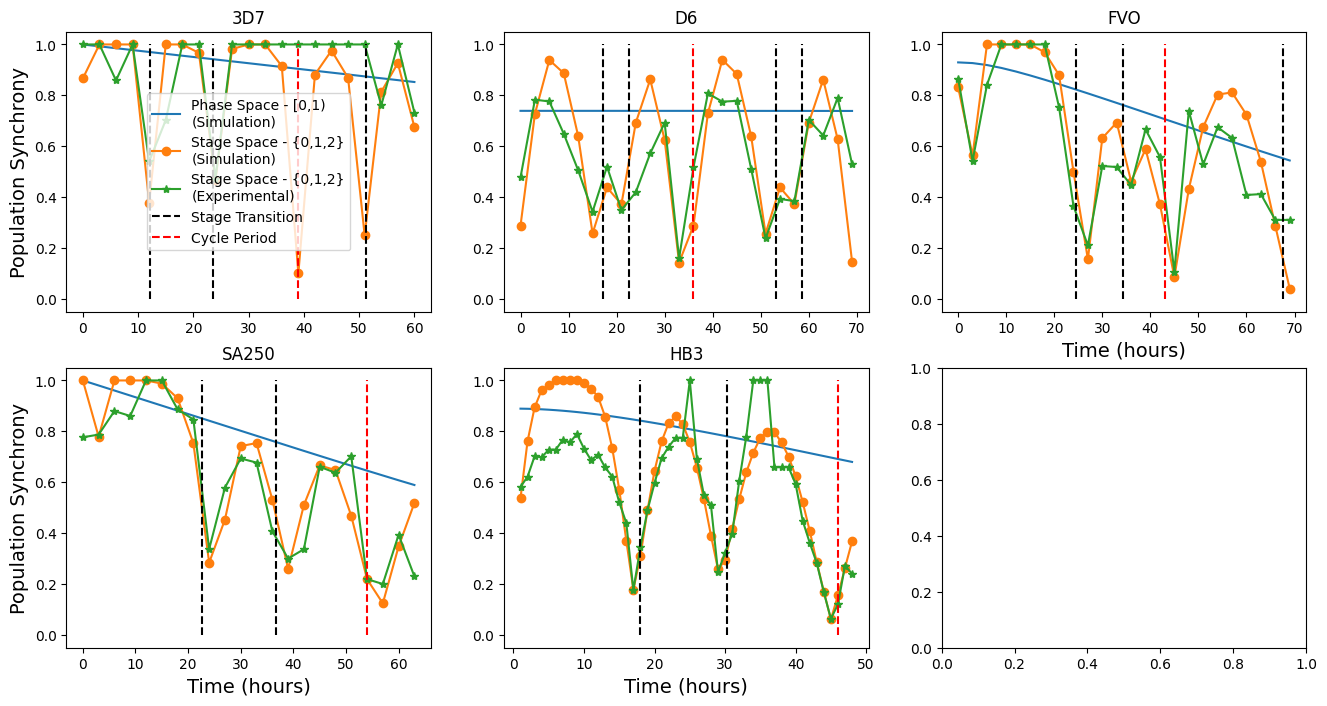

In [11]:
strains = ['3D7','D6','FVO','SA250','HB3'] 

# load optimal model parameters reported in [1]
opt_param_table = pd.read_csv('../data/pfalc/simulated/opt_params_table.csv', index_col=[0,1,2], header=[1])
opt_param_df = opt_param_table.iloc[[2,5,8,11,14]].reset_index()

synchrony_phases_sim_dict = dict()

fig, axs = plt.subplots(2, 3, figsize=(16,8))
axs = axs.flatten()
ai=0
for strain in strains:
    phases_sim_df = pd.read_csv(f'../data/pfalc/simulated/{strain}_simulated_phases.txt', header=0, index_col=0, sep='\t')
    stages_sim_df = pd.read_csv(f'../data/pfalc/simulated/{strain}_simulated_stages.txt', header=0, index_col=0, sep='\t')
    stages_exp_df = pd.read_csv(f'../data/pfalc/experimental/{strain}_sequenced_samples_staging.txt', header=0, index_col=0, sep='\t')

    # For this strain, extract the inferred intervals defining morphological stages
    rt_thresh = opt_param_df[opt_param_df['Strain']==strain]['theta_{RT}^*'].astype(float).values[0]
    ts_thresh = opt_param_df[opt_param_df['Strain']==strain]['theta_{TS}^*'].astype(float).values[0]
    a = np.array([0,rt_thresh, ts_thresh,1])
    
    
    # construct the normalization constant for this state space
    D = ps.discrete_general_circ_state_dm(a) # general_cyclic_state_dm(a)
    C = D*D
    normalization, _ = ps.finite_state_normalization(C) # finite_state_normalization(C)
    
    synchrony_phases_sim = np.zeros(phases_sim_df.index.values.shape, dtype=np.float64)
    synchrony_stages_sim = np.zeros(stages_sim_df.index.values.shape, dtype=np.float64)
    synchrony_stages_exp = np.zeros(stages_exp_df.index.values.shape, dtype=np.float64)
    for i in range(len(phases_sim_df.index.values)):
        synchrony_phases_sim[i] = ps.circ_synchrony(phases_sim_df.values[i,:], method='exact')[0] 
        synchrony_stages_sim[i] = ps.discrete_general_circ_synchrony(stages_sim_df.values[i,:], a=a, normalization=normalization)[0] 
        synchrony_stages_exp[i] = ps.discrete_general_circ_synchrony(stages_exp_df.values[i,:], a=a, normalization=normalization)[0] 
    synchrony_phases_sim_dict[strain] = (phases_sim_df.index.values, synchrony_phases_sim)

    period = opt_param_df[opt_param_df['Strain']==strain]['Period'].astype(float).values[0]
    stage_transitions = np.array([rt_thresh*period, ts_thresh*period, period, period*(1+rt_thresh), period*(1+ts_thresh), 2*period])
    stage_transitions = stage_transitions[stage_transitions<=phases_sim_df.index.values.max()]
    print(f'Strain: {strain}, transitions {a[1:3]} Period: {period}')
    if ai == 0:
        label1 = 'Phase Space - [0,1)\n(Simulation)'
        label2 = 'Stage Space - {0,1,2}\n(Simulation)'
        label3 = 'Stage Space - {0,1,2}\n(Experimental)'
    else:
        label1 = None
        label2 = None
        label3 = None
        
    axs[ai].plot(phases_sim_df.index.values, synchrony_phases_sim, '', label=label1)
    axs[ai].plot(stages_sim_df.index.values, synchrony_stages_sim, '-o', label=label2)
    axs[ai].plot(stages_exp_df.index.values, synchrony_stages_exp, '-*', label=label3)
    c=0
    
    for stage_transition in stage_transitions:
        if c==0:
            color='k'
            if ai == 0:
                label='Stage Transition'
            else:
                label = None
        elif c==2:
            color='red'
            if ai == 0:
                label='Cycle Period'
            else:
                label = None
        else:
            color='k'
            label=None
            
        axs[ai].plot([stage_transition, stage_transition], [0,1], '--', color=color, label=label)
        c=c+1
        
    if ai in [0,3]:
        axs[ai].set_ylabel('Population Synchrony', fontsize=14)

    if ai in [2,3,4]:
        axs[ai].set_xlabel('Time (hours)', fontsize=14)
    
    axs[ai].set_title(f'{strain}')   

    if ai==0:
        common_legend = axs[ai].legend(loc='center') 
        
    ai += 1

plt.savefig('../figs/science_reanalysis.svg')

### Further refine morphological stages into 2 or 3 sub-stages and recompute synchrony on the more refined discretizations of the circle

Strain: 3D7, \begin{bNiceMatrix}[first-col,first-row]   & 0 & 1 & 2\  0 & 0.000 & 0.301 & 0.355\  1 & 0.301 & 0.000 & 0.344\  2 & 0.355 & 0.344 & 0.000\ \end{bNiceMatrix}
Strain: 3D7, \begin{bNiceMatrix}[first-col,first-row]   & 0 & 1 & 2 & 3 & 4 & 5\  0 & 0.000 & 0.156 & 0.306 & 0.451 & 0.377 & 0.177\  1 & 0.156 & 0.000 & 0.150 & 0.295 & 0.467 & 0.334\  2 & 0.306 & 0.150 & 0.000 & 0.145 & 0.317 & 0.484\  3 & 0.451 & 0.295 & 0.145 & 0.000 & 0.172 & 0.371\  4 & 0.376 & 0.467 & 0.317 & 0.172 & 0.000 & 0.199\  5 & 0.177 & 0.334 & 0.484 & 0.371 & 0.199 & 0.000\ \end{bNiceMatrix}
Strain: 3D7, \begin{bNiceMatrix}[first-col,first-row]   & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8\  0 & 0.000 & 0.104 & 0.208 & 0.308 & 0.405 & 0.498 & 0.384 & 0.251 & 0.118\  1 & 0.104 & 0.000 & 0.104 & 0.204 & 0.301 & 0.398 & 0.488 & 0.355 & 0.222\  2 & 0.208 & 0.104 & 0.000 & 0.100 & 0.197 & 0.294 & 0.408 & 0.459 & 0.326\  3 & 0.308 & 0.204 & 0.100 & 0.000 & 0.097 & 0.193 & 0.308 & 0.441 & 0.427\  4 & 0.405 & 0.301 & 

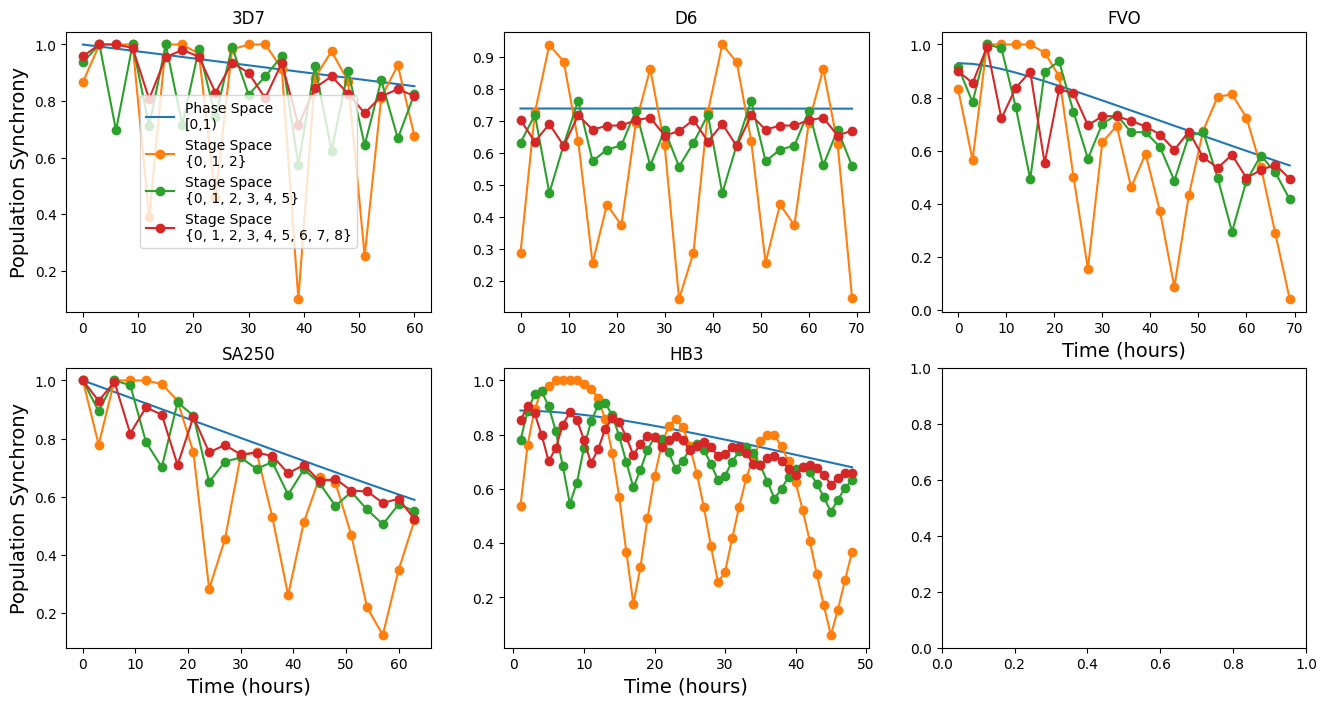

In [9]:
strains = ['3D7','D6','FVO','SA250', 'HB3'] 
refine_factors = [1, 2, 3]

# load optimal model parameters reported in [1]
opt_param_table = pd.read_csv('../data/pfalc/simulated/opt_params_table.csv', index_col=[0,1,2], header=[1])
opt_param_df = opt_param_table.iloc[[2,5,8,11,14]].reset_index()

fig, axs = plt.subplots(2, 3, figsize=(16,8))
axs = axs.flatten()
ai=0
synchrony_phases_sim_dict = dict()
for strain in strains:
    for refine_factor in refine_factors:
        phases_sim_df = pd.read_csv(f'../data/pfalc/simulated/{strain}_simulated_phases.txt', header=0, index_col=0, sep='\t')
        stages_sim_df = pd.read_csv(f'../data/pfalc/simulated/{strain}_simulated_stages.txt', header=0, index_col=0, sep='\t')
    
        # For this strain, extract (and optionally refine) the inferred intervals defining morphological stages
        rt_thresh = opt_param_df[opt_param_df['Strain']==strain]['theta_{RT}^*'].astype(float).values[0]
        ts_thresh = opt_param_df[opt_param_df['Strain']==strain]['theta_{TS}^*'].astype(float).values[0]

        a = [0, 1]
        for i in range(refine_factor):
            a = a + [(i+1)*rt_thresh/refine_factor]
            a = a + [rt_thresh + (i+1)*(ts_thresh-rt_thresh)/refine_factor]
            a = a + [ts_thresh + (i+1)*(1-ts_thresh)/refine_factor]
        a = np.unique(a)
      
        # build the staging dataframe
        stages_sim_df = pd.DataFrame(index=phases_sim_df.index, columns=np.arange(len(a)-1))
        for i in range(1,len(a)):
            stages_sim_df[i-1] = ((a[i-1]<=phases_sim_df) & (phases_sim_df<a[i])).sum(axis=1)/len(phases_sim_df.columns)

        # construct the normalization constant for this state space
        D = ps.discrete_general_circ_state_dm(a) # general_cyclic_state_dm(a)
        print(f'Strain: {strain}, {array2bnicematrix(D)}')
        C = D*D
        normalization, _ = ps.finite_state_normalization(C) # finite_state_normalization(C)
        
        synchrony_phases_sim = np.zeros(phases_sim_df.index.values.shape, dtype=np.float64)
        synchrony_stages_sim = np.zeros(stages_sim_df.index.values.shape, dtype=np.float64)
        for i in range(len(phases_sim_df.index.values)):
            synchrony_phases_sim[i] = ps.circ_synchrony(phases_sim_df.values[i,:], method='optimize')[0] # 1-circ_asynchrony(phases_sim_df.values[i,:], method='optimize')[0]
            synchrony_stages_sim[i] = ps.discrete_general_circ_synchrony(stages_sim_df.values[i,:], a=a, normalization=normalization)[0] # 1-general_discrete_circ_asynchrony(stages_sim_df.values[i,:], a=a, normalization=normalization)[0]
    
        synchrony_phases_sim_dict[strain] = (phases_sim_df.index.values, synchrony_phases_sim)
    
        period = opt_param_df[opt_param_df['Strain']==strain]['Period'].astype(float).values[0]

        if refine_factor == 1:
            if ai == 0:
                label1 = 'Phase Space\n[0,1)'
            else:
                label1 = None
            axs[ai].plot(phases_sim_df.index.values, synchrony_phases_sim, '', label=label1)
        if ai == 0:
            label2 = f'Stage Space\n{set(stages_sim_df.columns.values)}'
        else:
            label2 = None
        axs[ai].plot(stages_sim_df.index.values, synchrony_stages_sim, '-o', label=label2)
    
    axs[ai].set_title(f'{strain}')

    if ai in [2,3,4]:
        axs[ai].set_xlabel('Time (hours)', fontsize=14)
    
    if ai in [0,3]:
        axs[ai].set_ylabel('Population Synchrony', fontsize=14)

    if ai ==0:
        common_legend = axs[ai].legend(loc='center') 
    ai += 1
    
plt.savefig('../figs/science_reanalysis2.svg')